## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
%matplotlib inline

from scipy.sparse import coo_matrix
from scipy.sparse import hstack
from scipy.sparse import vstack
from scipy import sparse
from scipy.sparse import csr_matrix


#preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb

#metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

**Reading the data**

In [2]:
# train = pd.read_csv('/content/drive/MyDrive/Hamoye/premier/train_users_2.csv', 
#                     parse_dates=['date_account_created', 'timestamp_first_active', 'date_first_booking'])
# test = pd.read_csv('/content/drive/MyDrive/Hamoye/premier/test_users.csv',
#                    parse_dates=['date_account_created', 'timestamp_first_active', 'date_first_booking'])

train = pd.read_csv('C:\\Users\\Volker\\Documents\\2022\\Data Science\\Hamoye Internship\\Stage C - Premier Project\\airbnb-recruiting-new-user-bookings\\train_users_2.csv')
test = pd.read_csv('C:\\Users\\Volker\\Documents\\2022\\Data Science\\Hamoye Internship\\Stage C - Premier Project\\airbnb-recruiting-new-user-bookings\\test_users.csv')
sessions = pd.read_csv('C:\\Users\\Volker\\Documents\\2022\\Data Science\\Hamoye Internship\\Stage C - Premier Project\\airbnb-recruiting-new-user-bookings\\sessions.csv')

In [6]:
countries = pd.read_csv('C:\\Users\\Volker\\Documents\\2022\\Data Science\\Hamoye Internship\\Stage C - Premier Project\\airbnb-recruiting-new-user-bookings\\countries.csv')
age_bracket = pd.read_csv('C:\\Users\\Volker\\Documents\\2022\\Data Science\\Hamoye Internship\\Stage C - Premier Project\\airbnb-recruiting-new-user-bookings\\age_gender_bkts.csv')
ss = pd.read_csv('C:\\Users\\Volker\\Documents\\2022\\Data Science\\Hamoye Internship\\Stage C - Premier Project\\airbnb-recruiting-new-user-bookings\\sample_submission_NDF.csv')

In [7]:
train.head(2)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF


In [8]:
countries.head(2)

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.0
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.0


In [9]:
sessions.head(2)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0


In [11]:
age_bracket.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [12]:
train.describe()

,timestamp_first_active,age,signup_flow
count,2.134510e+05,125461.000000,213451.000000
mean,2.013085e+13,49.668335,3.267387
std,9.253717e+09,155.666612,7.637707
min,2.009032e+13,1.000000,0.000000
25%,2.012123e+13,28.000000,0.000000
50%,2.013091e+13,34.000000,0.000000
75%,2.014031e+13,43.000000,0.000000
max,2.014063e+13,2014.000000,25.000000


**Checking for missing values**

In [13]:
# Percentage of null values
train.isna().mean().sort_values(ascending=False)

date_first_booking         0.583473
age                        0.412226
first_affiliate_tracked    0.028414
id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
gender                     0.000000
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [14]:
# Splitting the columns
cat_cols = ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
           'signup_app', 'first_browser', 'first_device_type']
date_cols = ['date_account_created', 'timestamp_first_active', 'date_first_booking']
num_cols = ['age', 'signup_flow']

## Visualizations

In [15]:
plt.style.use('bmh') # to set the chart style

### Univariate Exploration

gender


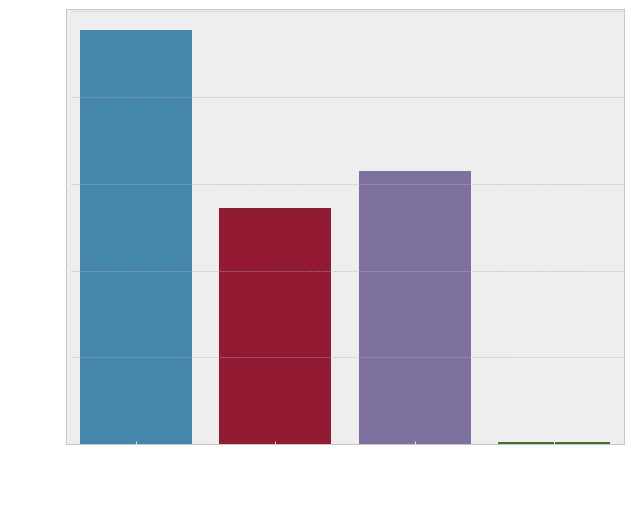

signup_method


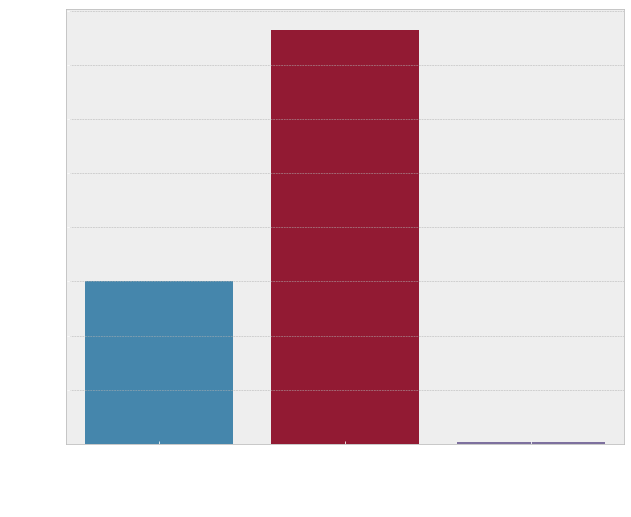

language


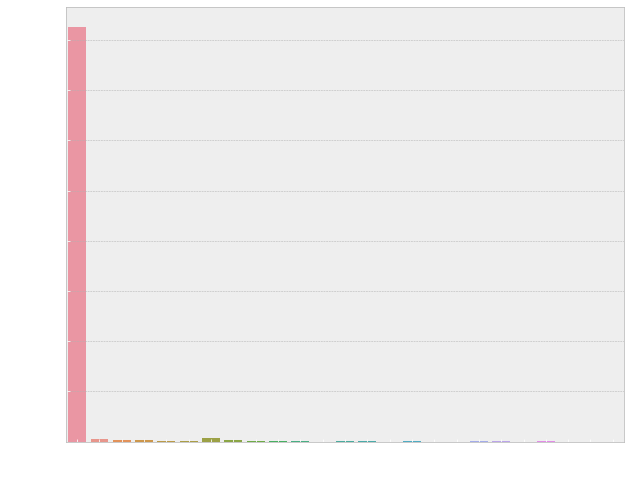

affiliate_channel


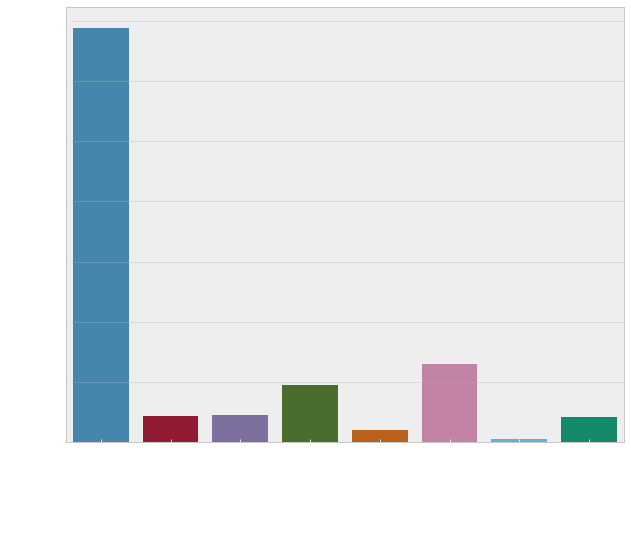

affiliate_provider


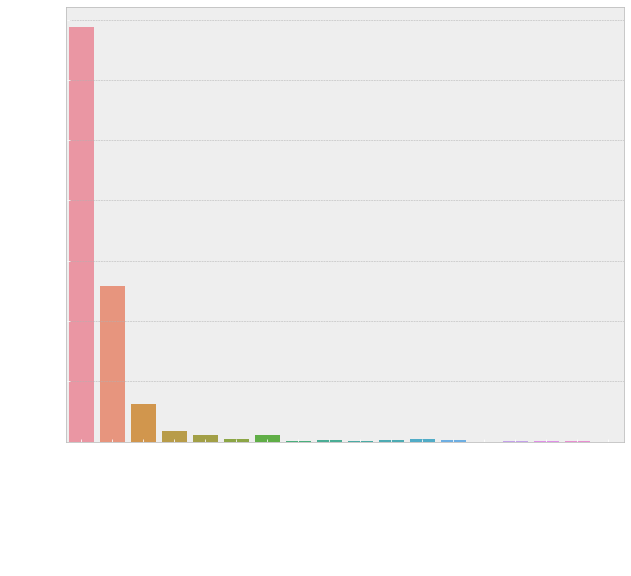

first_affiliate_tracked


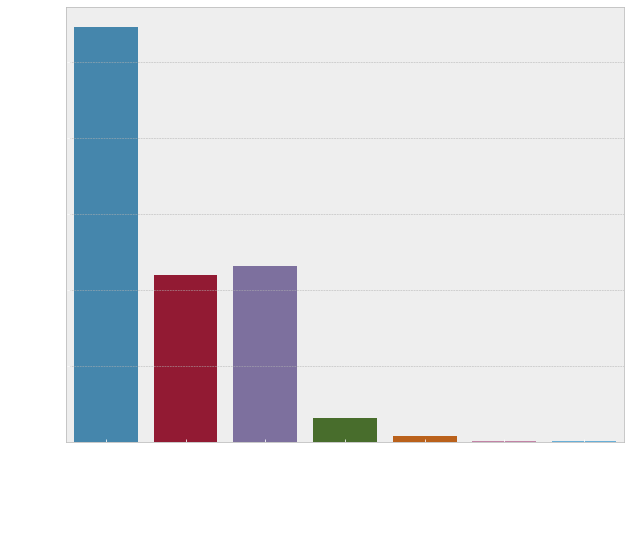

signup_app


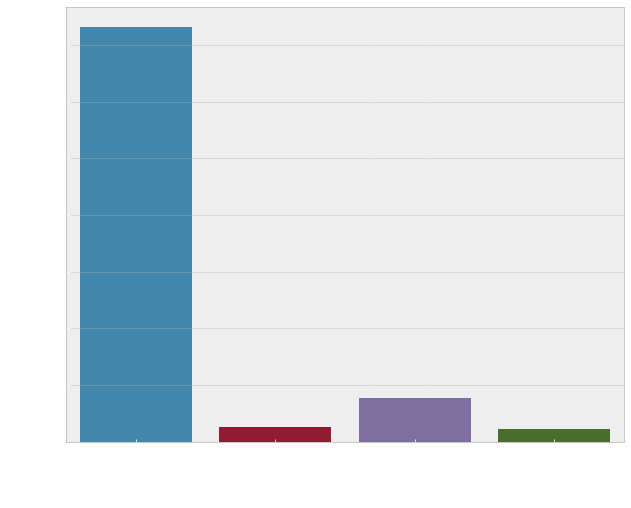

first_browser


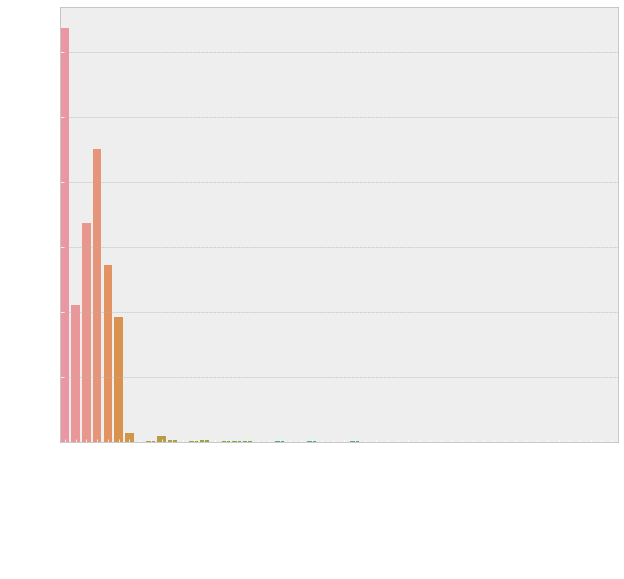

first_device_type


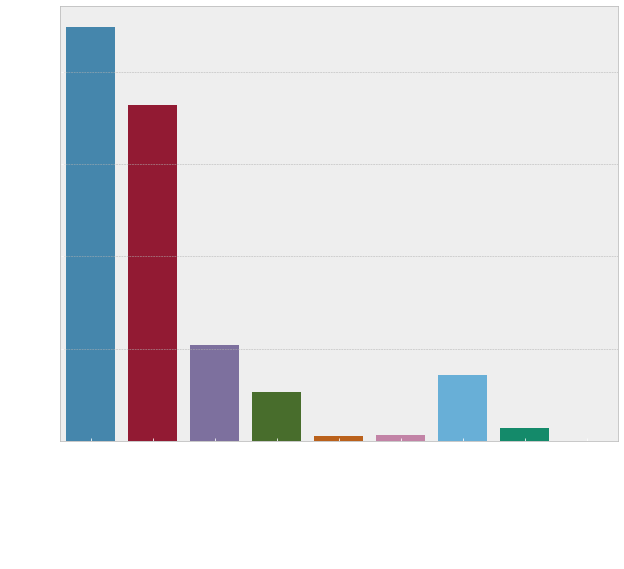

In [16]:
# Plotting categorical features
for cat in cat_cols:
    print(cat)
    plt.figure(figsize=(10,8))
    sns.countplot(x=cat, data=train)
    plt.xticks(rotation=90)
    plt.show()

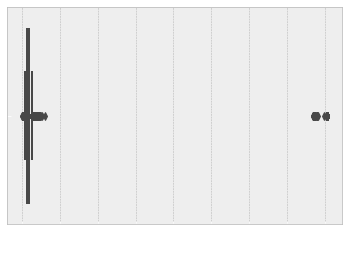

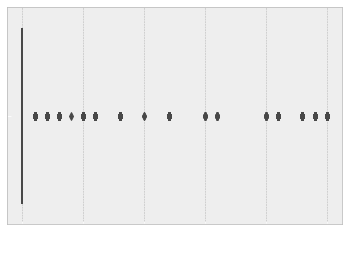

In [17]:
# Plotting numerical columns
for num in num_cols:
    sns.boxplot(x=num, data=train)
    plt.show()

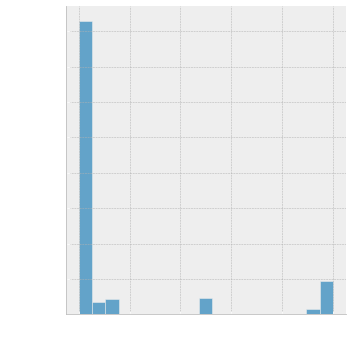

In [18]:
# checking the distribution of signup-flow
sns.displot(train['signup_flow']);

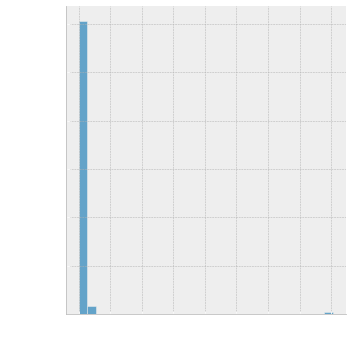

In [19]:
# checking the distribution of age
sns.displot(train['age'], bins=30);

### Bivariate Exploration

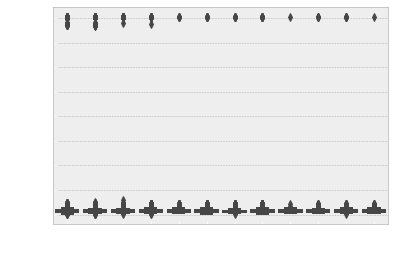

In [20]:
sns.boxplot(data = train, x = 'country_destination', y = 'age');

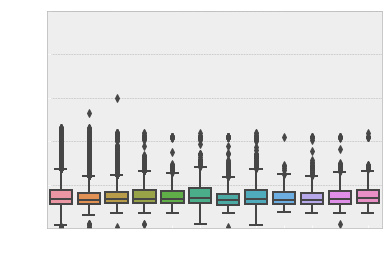

In [21]:
# zooming to focus on important data
sns.boxplot(data = train, x = 'country_destination', y = 'age')
plt.ylim((0, 250));

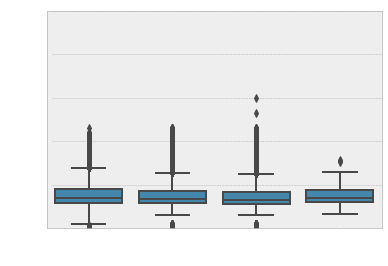

In [22]:
sns.boxplot(data = train, x = 'gender', y = 'age', color = sns.color_palette()[0])
plt.ylim((0, 250));

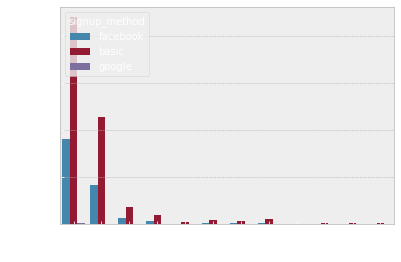

In [23]:
sns.countplot(data = train, x = 'country_destination', hue = 'signup_method');

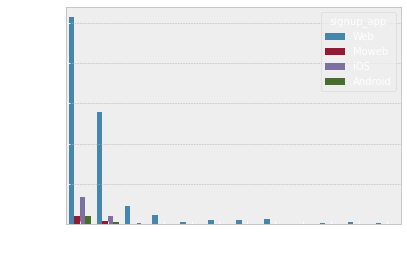

In [24]:
sns.countplot(data = train, x = 'country_destination', hue = 'signup_app');

### Multivariate Exploration

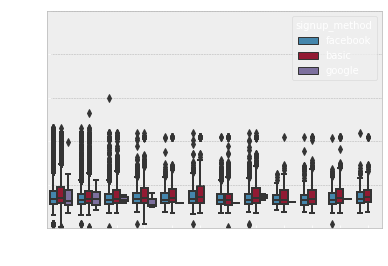

In [25]:
sns.boxplot(data = train, x = 'country_destination', y = 'age', hue = 'signup_method')
plt.ylim((0, 250));

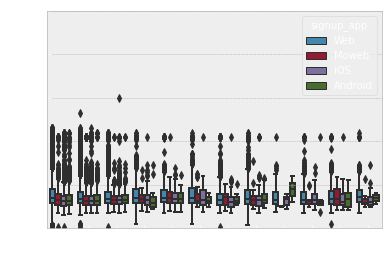

In [26]:
sns.boxplot(data = train, x = 'country_destination', y = 'age', hue = 'signup_app')
plt.ylim((0, 250));

Age column has outliers

Checking the percentage of outliers of Age

In [27]:
# defining the quartiles
q1 = 28
q3 = 43

iqr = 43 - 28 # interquartile range = 15

low_range = q1 - 1.5*iqr
high_range = q3 + 1.5*iqr

# checking the number of observations and percentage of outliers
no_outliers = train[(train['age']<low_range) | (train['age']>high_range)].shape[0]
perc_outliers = no_outliers/train.shape[0] * 100

print(f'The percentage of age outliers is {round(perc_outliers, 4)}%')

The percentage of age outliers is 2.6207%


Suggestion - the outliers could be filled by the median

**How is the country_destination distributed**

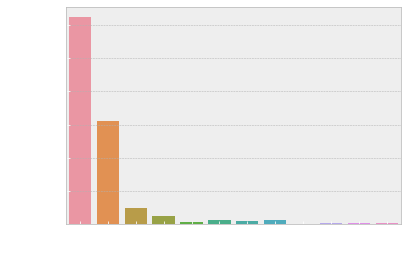

In [29]:
sns.countplot(x='country_destination', data=train);

Many people actually didn't make a booking

Most people from Travelled from US to US 

In [30]:
train['country_destination'].value_counts()

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

In [31]:
# checking how many classes are in each categorical column
train[train.columns.difference(num_cols + date_cols + ['id'])].nunique().sort_values(ascending=False)

first_browser              52
language                   25
affiliate_provider         18
country_destination        12
first_device_type           9
affiliate_channel           8
first_affiliate_tracked     7
gender                      4
signup_app                  4
signup_method               3
dtype: int64

In [32]:
train.head(2)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF


In [33]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       62096 non-null  object 
 1   date_account_created     62096 non-null  object 
 2   timestamp_first_active   62096 non-null  int64  
 3   date_first_booking       0 non-null      float64
 4   gender                   62096 non-null  object 
 5   age                      33220 non-null  float64
 6   signup_method            62096 non-null  object 
 7   signup_flow              62096 non-null  int64  
 8   language                 62096 non-null  object 
 9   affiliate_channel        62096 non-null  object 
 10  affiliate_provider       62096 non-null  object 
 11  first_affiliate_tracked  62076 non-null  object 
 12  signup_app               62096 non-null  object 
 13  first_device_type        62096 non-null  object 
 14  first_browser         

## Data Cleaning

### Cleaning Step 1: Filling null values with median as well as replacing the outliers with the median

In [34]:
train['age']=np.where((train['age'].isnull())|(train["age"] > 120) |(train["age"] < 10 ), train['age'].median(), train['age'])

#### Testing

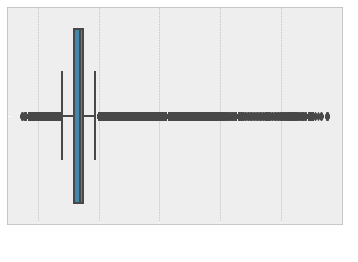

In [35]:
sns.boxplot(x= 'age', data=train);

In [36]:
test['age']=np.where((test['age'].isnull())|(test["age"] > 120) |(test["age"] < 10 ), test['age'].median(), test['age'])

#### Testing

In [37]:
test.isna().sum()

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         62096
gender                         0
age                            0
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked       20
signup_app                     0
first_device_type              0
first_browser                  0
dtype: int64

### Cleaning Step 2: Dropping the `date_first_booking` column as the null values represent the users who did not travel

In [38]:
# t = train.dropna(subset=['date_first_booking']) changed this to dropping the whole column

train.drop(columns = ['date_first_booking'], inplace = True)

#### Testing

In [39]:
# t.isna().sum()

train.isna().sum()

id                            0
date_account_created          0
timestamp_first_active        0
gender                        0
age                           0
signup_method                 0
signup_flow                   0
language                      0
affiliate_channel             0
affiliate_provider            0
first_affiliate_tracked    6065
signup_app                    0
first_device_type             0
first_browser                 0
country_destination           0
dtype: int64

In [40]:
# t = test.dropna(subset=['date_first_booking']) changed this to dropping the whole column

test.drop(columns = ['date_first_booking'], inplace = True)

#### Testing

In [41]:
# t.isna().sum()

test.isna().sum()

id                          0
date_account_created        0
timestamp_first_active      0
gender                      0
age                         0
signup_method               0
signup_flow                 0
language                    0
affiliate_channel           0
affiliate_provider          0
first_affiliate_tracked    20
signup_app                  0
first_device_type           0
first_browser               0
dtype: int64

### Cleaning Step 3: Filling missing `first_affiliate_tracked` with forward fill

In [42]:
# train_=t['first_affiliate_tracked'].fillna(method='ffill') changed this
#train_

train['first_affiliate_tracked'].fillna(method='ffill', inplace = True)

#### Testing

In [43]:
# train_.isna().sum()

train.isna().sum()

id                         0
date_account_created       0
timestamp_first_active     0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dtype: int64

In [44]:
# test_=t['first_affiliate_tracked'].fillna(method='ffill') changed this
#test_

test['first_affiliate_tracked'].fillna(method='ffill', inplace = True)

#### Testing

In [45]:
# test_.isna().sum()

test.isna().sum()

id                         0
date_account_created       0
timestamp_first_active     0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
dtype: int64

### Cleaning Step 4: Renaming `id` to `user_id`

In [46]:
train.rename(columns = {'id': 'user_id'}, inplace = True)

#### Testing

In [47]:
train.sample()

,user_id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
31937,in5u57k9lb,2012-07-14,20120714181346,MALE,34.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,US


In [48]:
test.rename(columns = {'id': 'user_id'}, inplace = True)

#### Testing

In [49]:
test.sample()

,user_id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
14931,403q1kipqw,2014-07-23,20140723075627,MALE,22.0,facebook,0,en,direct,direct,linked,Web,Mac Desktop,Safari


## Baseline Model

### Encoding and Feature Engineering

In [50]:
trial = pd.get_dummies(data = train, columns = cat_cols, drop_first=True)

In [52]:
trial.set_index('user_id', inplace = True)

In [53]:
trial.drop(labels = ['date_account_created', 'timestamp_first_active'], axis = 1, inplace = True)

In [54]:
# setting the mapping for the target variables
class_dict = {
    'NDF': 0,
    'US': 1,
    'other': 2,
    'FR': 3,
    'CA': 4,
    'GB': 5,
    'ES': 6,
    'IT': 7,
    'PT': 8,
    'NL': 9,
    'DE': 10,
    'AU': 11
}

In [55]:
X = trial.drop(labels = ['country_destination'], axis = 1)
y = trial.loc[:, 'country_destination'].apply(lambda x: class_dict[x])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, stratify=y)

In [16]:
# classifiers = [KNeighborsClassifier(), RandomForestClassifier(verbose = 1), GradientBoostingClassifier(verbose = 1)]
# for classifier in classifiers:
#     classifier.fit(X_train, y_train)
#     print('Score: ' + str(classifier.score(X_test, y_test)))

##### The best performing model was the GradientBoostingClassifier with a 62.9% accuracy score. The least performing was the KNeighborsClassifier with 58.67% accuracy. Thus, we would try to tune the GradientBoostingClassifier

### Using randomizedsearchcv to try to improve the model

In [28]:
# parameters = {
#     'n_estimators' : [100, 200],
#     'max_features' : ['auto', 'log2'],
#     'max_depth': [3, 5]
# }

In [29]:
# rcv = RandomizedSearchCV(estimator = GradientBoostingClassifier(), param_distributions=parameters, n_iter = 3, n_jobs = 3, verbose = 3)

In [ ]:
# rcv.fit(X_train, y_train)

In [ ]:
# rcv.best_params_
# #{'n_estimators': 100, 'max_features': 'auto', 'max_depth': 5}

In [ ]:
# rcv.best_score_
# 0.6300846878356539

##### Since our best model still performs slightly above 63%, we would need to apply more feature engineering as we hope to beat our baseline model score

## Second Model

### Cleaning & Aggregating sessions data to be merged with train and test datasets

In [57]:
sessions.isnull().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

In [58]:
sessions.sample()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
5999288,g2vq6crwb1,show,view,p1,Windows Desktop,163793.0


In [59]:
# formatting the device type values
sessions.device_type = sessions.device_type.str.replace(' ',"_")

In [60]:
#Handing the NaN values repaceing with mode of column
sessions['action'].fillna(sessions['action'].mode()[0], inplace=True)
sessions['action_type'].fillna(sessions['action_type'].mode()[0], inplace=True)
sessions['action_detail'].fillna(sessions['action_detail'].mode()[0], inplace=True)
sessions['device_type'].fillna(sessions['device_type'].mode()[0], inplace=True)
sessions['secs_elapsed'].fillna(0, inplace=True)

In [61]:
new_sessions = sessions.groupby('user_id', as_index = False).agg(lambda x: x.tolist())

In [62]:
# dropping rows with missing user_id
new_sessions.dropna(axis = 0, subset = 'user_id', inplace = True)

In [63]:
new_sessions.shape

(135483, 6)

In [64]:
new_sessions.isnull().sum()

user_id          0
action           0
action_type      0
action_detail    0
device_type      0
secs_elapsed     0
dtype: int64

In [65]:
def convert_to_string(action):
    '''
    Function to convert each action to a string
    '''
    action = [str(i) for i in action]
    action = [re.sub("nan","",i) for i in action]
    action = ",".join(action)
    
    return action

In [66]:
# applying the function
new_sessions["action"] = new_sessions["action"].apply(convert_to_string)
new_sessions["action_type"] = new_sessions["action_type"].apply(convert_to_string)
new_sessions["action_detail"] = new_sessions["action_detail"].apply(convert_to_string)

In [67]:
def convert_to_set(device):
    '''
    Function to get the unique device types
    '''
    device = [str(i) for i in device]
    device = [re.sub("nan","",i) for i in device]
    device = ",".join(set(device))
    
    return device

In [68]:
# applying the function
new_sessions['device_type'] = new_sessions.device_type.apply(convert_to_set)

In [69]:
def convert_the_time(time):
    '''
    Function to convert the elapsed seconds to time
    '''
    float_time = []
    time = [str(i) for i in time]
    time = [re.sub("nan","",i) for i in time]
    
    for i in time:
        try:
            float_time.append(float(i))
        except ValueError :
            continue

    time = sum(float_time)
    
    return time

In [70]:
# applying the function
new_sessions['secs_elapsed'] = new_sessions.secs_elapsed.apply(convert_the_time)

In [71]:
new_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135483 entries, 0 to 135482
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        135483 non-null  object 
 1   action         135483 non-null  object 
 2   action_type    135483 non-null  object 
 3   action_detail  135483 non-null  object 
 4   device_type    135483 non-null  object 
 5   secs_elapsed   135483 non-null  float64
dtypes: float64(1), object(5)
memory usage: 6.2+ MB


##### Merging the train and sessions dataframes

In [72]:
train_merge = train.merge(new_sessions, left_on = 'user_id', right_on = 'user_id', how = 'inner')

In [73]:
train_merge.head(2)

,user_id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,2014-01-01,20140101000936,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,"lookup,search_results,lookup,search_results,lo...","view,click,view,click,view,click,view,data,vie...","view_search_results,view_search_results,view_s...","Windows_Desktop,-unknown-",3427529.0
1,yo8nz8bqcq,2014-01-01,20140101001558,-unknown-,34.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,"dashboard,create,confirm_email,show,show_perso...","view,submit,click,view,data,view,data,data,view","dashboard,create_user,confirm_email_link,p3,us...",Mac_Desktop,207842.0


In [74]:
print('Train:', train.shape)
print('Sessions:', sessions.shape)
print('Train_merge:', train_merge.shape)

Train: (213451, 15)
Sessions: (10567737, 6)
Train_merge: (73815, 20)


In [75]:
train_merge.isnull().sum()

user_id                    0
date_account_created       0
timestamp_first_active     0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
action                     0
action_type                0
action_detail              0
device_type                0
secs_elapsed               0
dtype: int64

##### Obs: There are 73815 users with session data

#### Performing same for the test dataset

In [76]:
test_merge = test.merge(new_sessions, left_on = 'user_id', right_on = 'user_id', how = 'left')

print('Test:', test.shape)
print('Sessions:', sessions.shape)
print('Test_merge:', test_merge.shape)

Test: (62096, 14)
Sessions: (10567737, 6)
Test_merge: (62096, 19)


In [77]:
test_merge.isnull().sum()

user_id                      0
date_account_created         0
timestamp_first_active       0
gender                       0
age                          0
signup_method                0
signup_flow                  0
language                     0
affiliate_channel            0
affiliate_provider           0
first_affiliate_tracked      0
signup_app                   0
first_device_type            0
first_browser                0
action                     428
action_type                428
action_detail              428
device_type                428
secs_elapsed               428
dtype: int64

In [78]:
test_merge["action"].fillna("na", inplace = True)
test_merge["action_type"].fillna("na", inplace = True)
test_merge["action_detail"].fillna("na", inplace = True)
test_merge["device_type"].fillna("na", inplace = True)
test_merge["secs_elapsed"].fillna(0, inplace = True)

In [79]:
test_merge.isnull().sum()

user_id                    0
date_account_created       0
timestamp_first_active     0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
action                     0
action_type                0
action_detail              0
device_type                0
secs_elapsed               0
dtype: int64

### Date feature engineering

In [80]:
# for train
train_merge["date_account_created"] = pd.to_datetime(train_merge["date_account_created"])
train_merge["date_account_created_day"] = train_merge.date_account_created.dt.weekday
train_merge["date_account_created_month"] = train_merge.date_account_created.dt.month
train_merge["date_account_created_year"] = train_merge.date_account_created.dt.year

# for test
test_merge["date_account_created"] = pd.to_datetime(test_merge["date_account_created"])
test_merge["date_account_created_day"] = test_merge.date_account_created.dt.weekday
test_merge["date_account_created_month"] = test_merge.date_account_created.dt.month
test_merge["date_account_created_year"] = test_merge.date_account_created.dt.year

In [81]:
def convert_timestamp_first_active(timestamp):
    '''
    Function to help convert timestamp entry to timestamp object
    '''
        
    timestamp = str(timestamp)
        
    timestamp = datetime(year=int(timestamp[0:4]), month=int(timestamp[4:6]), day=int(timestamp[6:8]),\
                             
                             hour=int(timestamp[8:10]), minute=int(timestamp[10:12]), second=int(timestamp[12:]))
        
    return timestamp

In [82]:
# for train
train_merge['timestamp_first_active'] = pd.to_datetime(train_merge.timestamp_first_active.apply(convert_timestamp_first_active))
train_merge["timestamp_first_active_day"] = train_merge.timestamp_first_active.dt.weekday
train_merge["timestamp_first_active_month"] = train_merge.timestamp_first_active.dt.month
train_merge["timestamp_first_active_year"] = train_merge.timestamp_first_active.dt.year
train_merge["timestamp_first_active_hour"] = train_merge.timestamp_first_active.dt.hour

# for test
test_merge['timestamp_first_active'] = pd.to_datetime(test_merge.timestamp_first_active.apply(convert_timestamp_first_active))
test_merge['timestamp_first_active_day'] = test_merge.timestamp_first_active.dt.weekday
test_merge['timestamp_first_active_month'] = test_merge.timestamp_first_active.dt.month
test_merge['timestamp_first_active_year'] = test_merge.timestamp_first_active.dt.year
test_merge['timestamp_first_active_hour'] = test_merge.timestamp_first_active.dt.hour 

In [83]:
train_merge.isnull().sum()

user_id                         0
date_account_created            0
timestamp_first_active          0
gender                          0
age                             0
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked         0
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
action                          0
action_type                     0
action_detail                   0
device_type                     0
secs_elapsed                    0
date_account_created_day        0
date_account_created_month      0
date_account_created_year       0
timestamp_first_active_day      0
timestamp_first_active_month    0
timestamp_first_active_year     0
timestamp_first_active_hour     0
dtype: int64

In [84]:
train_merge.sample()

,user_id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,action_detail,device_type,secs_elapsed,date_account_created_day,date_account_created_month,date_account_created_year,timestamp_first_active_day,timestamp_first_active_month,timestamp_first_active_year,timestamp_first_active_hour
625,asxockumf4,2014-01-03,2014-01-03 13:10:56,-unknown-,34.0,basic,23,en,direct,direct,...,"-unknown-,-unknown-,-unknown-,-unknown-,-unkno...",Android_App_Unknown_Phone/Tablet,197335.0,4,1,2014,4,1,2014,13


## Encoding

In [85]:
# make one hot encoded columns

encoded_list = []
ohe = ['gender', 'signup_method', 'language', 'affiliate_channel',\
            'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']

for col in ohe:
    train_ohe = pd.get_dummies(train_merge[col],prefix = col)
    train_merge.drop([col], axis = 1, inplace = True)
    
    test_ohe = pd.get_dummies(test_merge[col], prefix = col)
    test_merge.drop([col], axis = 1, inplace = True)
    
    encoded_list.append(train_ohe.columns)
    
    # Get missing columns in the training test
    
    missing_cols = set( train_ohe.columns ) - set( test_ohe.columns )
    
    # Add a missing column in test set with default value equal to 0
    
    for c in missing_cols:
        test_ohe[c] = 0
        
    # Ensure the order of column in the test set is in the same order than in train set
    test_ohe = test_ohe[train_ohe.columns]
    
    train_merge = pd.concat((train_merge, train_ohe), axis=1)    
        
    test_merge = pd.concat((test_merge, test_ohe), axis=1)

In [86]:
# OHEfor `device_type` column

train_ohe = train_merge['device_type'].str.get_dummies(sep=",")
train_merge.drop(['device_type'], axis=1, inplace = True)
    
test_ohe = test_merge['device_type'].str.get_dummies(sep=",")
test_merge.drop(['device_type'], axis=1, inplace = True)
        
# Get missing columns in the training test
missing_cols = set( train_ohe.columns ) - set( test_ohe.columns )

encoded_list.append(train_ohe.columns)
    
# Add a missing column in test set with default value equal to 0
    
for c in missing_cols:
    test_ohe[c] = 0
        
# Ensure the order of column in the test set is in the same order than in train set
test_ohe = test_ohe[train_ohe.columns]
    
train_merge = pd.concat((train_merge, train_ohe), axis=1)    
        
test_merge = pd.concat((test_merge, test_ohe), axis=1)

In [87]:
train_merge.sample()

,user_id,date_account_created,timestamp_first_active,age,signup_flow,country_destination,action,action_type,action_detail,secs_elapsed,...,Chromebook,Linux_Desktop,Mac_Desktop,Opera_Phone,Tablet,Windows_Desktop,Windows_Phone,iPad_Tablet,iPhone,iPodtouch
23860,8vdlfqi1uu,2014-03-12,2014-03-12 22:29:27,23.0,0,NDF,"header_userpic,authenticate,header_userpic,sea...","data,submit,data,click,click,view,click,submit...","header_userpic,login,header_userpic,view_searc...",39599.0,...,0,0,0,0,0,1,0,0,0,0


In [88]:
train_merge.columns

Index(['user_id', 'date_account_created', 'timestamp_first_active', 'age',
       'signup_flow', 'country_destination', 'action', 'action_type',
       'action_detail', 'secs_elapsed',
       ...
       'Chromebook', 'Linux_Desktop', 'Mac_Desktop', 'Opera_Phone', 'Tablet',
       'Windows_Desktop', 'Windows_Phone', 'iPad_Tablet', 'iPhone',
       'iPodtouch'],
      dtype='object', length=142)

In [89]:
# setting the target variable
y = train_merge['country_destination']

In [90]:
# dropping redundant features
train_merge.drop(['user_id','date_account_created','timestamp_first_active',\
                  'country_destination','user_id'],axis=1,inplace = True)

test_merge.drop(['user_id','date_account_created','timestamp_first_active',\
                  'user_id'],axis=1,inplace = True)

In [92]:
print(train_merge.shape)
print(test_merge.shape)

(73815, 138)
(62096, 138)


### Vectorization

In [93]:
def tokens(x):
    '''
    Custom tokenizer function
    '''
    return x.split(',')

In [94]:
# on `action` feature
action_vectorizer = TfidfVectorizer(min_df = 10, max_features = 5000, tokenizer = tokens)

action_vectorizer.fit(train_merge['action'].values)

train_action_tfidf = action_vectorizer.transform(train_merge.action.values)
test_action_tfidf = action_vectorizer.transform(test_merge.action.values)

c:\Users\Volker\anaconda3\envs\udacity\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [95]:
print(train_action_tfidf.shape)
print(test_action_tfidf.shape)

(73815, 255)
(62096, 255)


In [96]:
# getting a list of some of the feature names
action_features = action_vectorizer.get_feature_names()

action_features[:5]

c:\Users\Volker\anaconda3\envs\udacity\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['10', '11', '12', '15', 'about_us']

In [97]:
# on `action_type` feature
action_type_vectorizer = TfidfVectorizer(min_df = 10, max_features = 5000, tokenizer = tokens)

action_type_vectorizer.fit(train_merge['action_type'].values)

train_action_type_tfidf = action_type_vectorizer.transform(train_merge.action_type.values)
test_action_type_tfidf = action_type_vectorizer.transform(test_merge.action_type.values)

In [98]:
print(train_action_type_tfidf.shape)
print(test_action_type_tfidf.shape)

(73815, 8)
(62096, 8)


In [99]:
# getting a list of some of the feature names
action_type_features = action_type_vectorizer.get_feature_names()

action_type_features[:5]

['-unknown-', 'booking_request', 'click', 'data', 'message_post']

In [100]:
# on `action_detail` feature
action_detail_vectorizer = TfidfVectorizer(min_df = 10, max_features = 5000, tokenizer = tokens)

action_detail_vectorizer.fit(train_merge['action_detail'].values)

train_action_detail_tfidf = action_detail_vectorizer.transform(train_merge.action_detail.values)
test_action_detail_tfidf = action_detail_vectorizer.transform(test_merge.action_type.values)

In [101]:
print(train_action_detail_tfidf.shape)
print(test_action_detail_tfidf.shape)

(73815, 121)
(62096, 121)


In [102]:
# getting a list of some of the feature names
action_detail_features = action_detail_vectorizer.get_feature_names()

action_detail_features[:5]

['-unknown-',
 'account_notification_settings',
 'account_payout_preferences',
 'account_privacy_settings',
 'account_transaction_history']

In [103]:
# drop redundant columns
train_merge.drop(['action','action_type','action_detail'],axis=1,inplace = True)

test_merge.drop(['action','action_type','action_detail'],axis=1,inplace = True)

In [104]:
col_lst = [i for i in train_merge.columns]

col_lst[:5]

['age',
 'signup_flow',
 'secs_elapsed',
 'date_account_created_day',
 'date_account_created_month']

In [105]:
# get all feature names
col_lst.extend(action_features)

col_lst.extend(action_type_features)

col_lst.extend(action_detail_features)


len(col_lst)

519

### Combining the data with our train dataframe

In [106]:
train_merge_tfidf = hstack((train_merge, train_action_tfidf,train_action_type_tfidf, train_action_detail_tfidf)).tocsr()
test_merge_tfidf = hstack((test_merge, test_action_tfidf,test_action_type_tfidf, test_action_detail_tfidf)).tocsr()

In [107]:
test_merge_tfidf.shape

(62096, 519)

## Training

In [109]:
type(train_merge_tfidf)

scipy.sparse.csr.csr_matrix

In [110]:
# encoding the target variables
le = LabelEncoder()

y = le.fit_transform(y)

In [111]:
# https://www.kaggle.com/davidgasquez/ndcg-scorer
# setting the ndcg scorer


def dcg_score(y_true, y_score, k=5):
    
    """Discounted cumulative gain (DCG) at rank K.

    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.

    Returns
    -------
    score : float
    """
    
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):
    
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    
    lb = LabelBinarizer()
    lb.fit(range(predictions.shape[1] + 1))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)


# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

In [112]:
gb = GradientBoostingClassifier()

In [113]:
X_train, X_test, y_train, y_test = train_test_split(train_merge_tfidf,y, test_size =0.25 , random_state = 42)

In [114]:
gb.fit(X_train, y_train)

GradientBoostingClassifier()

In [ ]:
gb.get_params()

# {'ccp_alpha': 0.0,
#  'criterion': 'friedman_mse',
#  'init': None,
#  'learning_rate': 0.1,
#  'loss': 'log_loss',
#  'max_depth': 3,
#  'max_features': None,
#  'max_leaf_nodes': None,
#  'min_impurity_decrease': 0.0,
#  'min_samples_leaf': 1,
#  'min_samples_split': 2,
#  'min_weight_fraction_leaf': 0.0,
#  'n_estimators': 100,
#  'n_iter_no_change': None,
#  'random_state': None,
#  'subsample': 1.0,
#  'tol': 0.0001,
#  'validation_fraction': 0.1,
#  'verbose': 0,
#  'warm_start': False}

In [115]:
y_pred = gb.predict_proba(train_merge_tfidf)

scored = ndcg_score(y, y_pred)

In [117]:
scored * 100

87.24310137425141

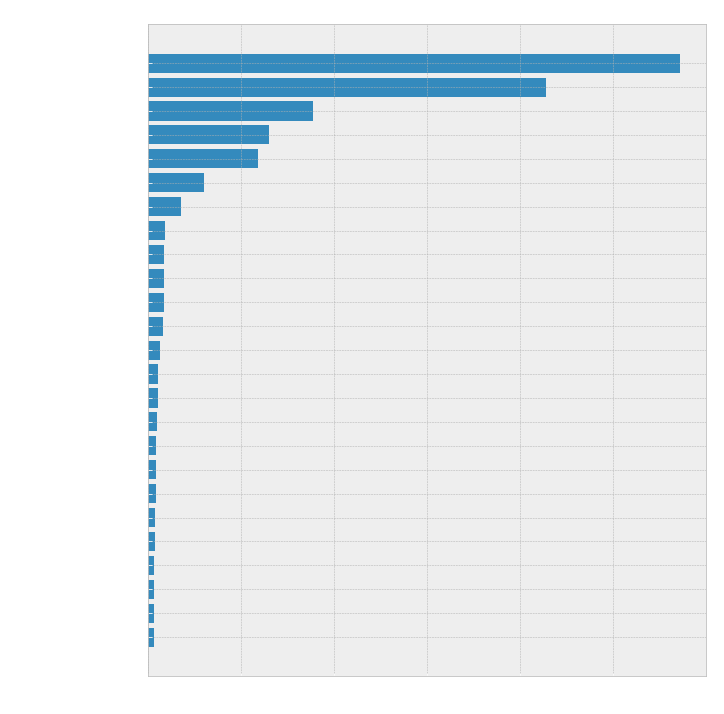

In [131]:
features = col_lst
importances = gb.feature_importances_

indices = (np.argsort(importances))[-25:]
plt.figure(figsize = (10, 12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align = 'center')

plt.yticks(ticks = range(len(indices)), labels = [features[i] for i in indices])
plt.xlabel('Importances (relative)')
plt.show()

#### Top features

In [132]:
top_80 = int(len(gb.feature_importances_)*0.8)

indices = (np.argsort(importances))[::-1][:top_80]

In [133]:
top_80

415

#### Reducing features based on important features

In [134]:
cols = []

for i in indices:
    
    cols.append(train_merge_tfidf[:,i])
    
train_merge_tfidf_new = hstack(cols)

cols = []

for i in indices:
    
    cols.append(test_merge_tfidf[:,i])
    
test_merge_tfidf_new = hstack(cols)

col_lst_new = []

for i in indices:
    
     col_lst_new.append(col_lst[i])

In [136]:
gb.fit(train_merge_tfidf_new, y)

GradientBoostingClassifier()

In [167]:
# standard accuracy score
print(gb.score(train_merge_tfidf_new, y) * 100)

72.68034952245479


In [138]:
new_pred = gb.predict_proba(train_merge_tfidf_new)

scored = ndcg_score(y, new_pred, k = 5)
scored

0.8756574675712561

#### New feature importances

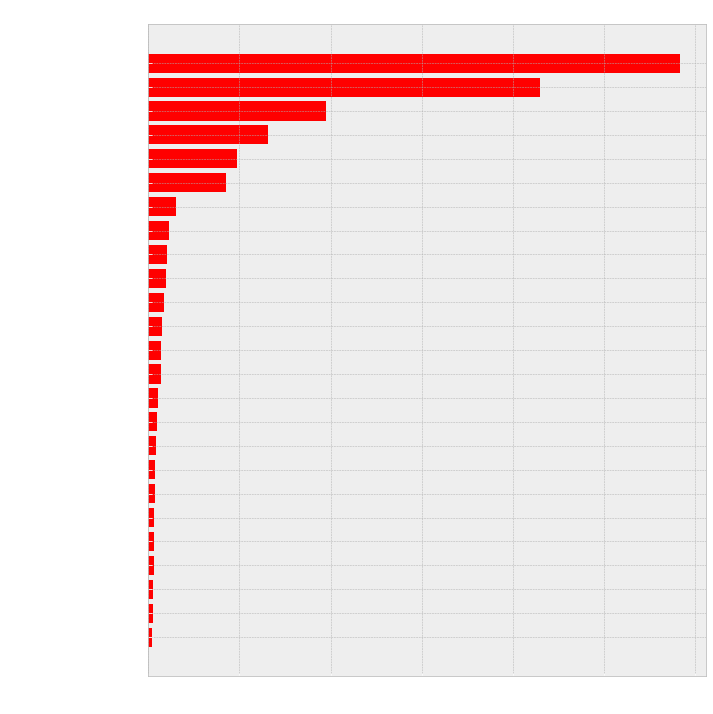

In [139]:
features = col_lst_new
importances = gb.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [145]:
test_id = test.user_id.values
test_id

array(['5uwns89zht', 'jtl0dijy2j', 'xx0ulgorjt', ..., 'fa6260ziny',
       '87k0fy4ugm', '9uqfg8txu3'], dtype=object)

## Predictions

In [146]:
test_pred = gb.predict_proba(test_merge_tfidf_new)

In [154]:
test_pred.shape

(62096, 12)

### Creating submissions file

In [163]:
#Taking the 5 classes with highest probabilities
ids = []  #list of ids
countries = []  #list of countries
for i in range(len(test_id)):
    idx = test_id[i]
    ids += [idx] * 5
    countries += le.inverse_transform(np.argsort(test_pred[i])[::-1])[:5].tolist()
# Generate submission
sub = pd.DataFrame(np.column_stack((ids, countries)), columns=['id', 'country'])
sub.to_csv('random_forest_submission.csv',index=False)

In [160]:
countries[:10]

['NDF', 'US', 'other', 'FR', 'GB', 'US', 'NDF', 'other', 'FR', 'IT']

In [164]:
sub.head(10)

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,GB
5,jtl0dijy2j,US
6,jtl0dijy2j,NDF
7,jtl0dijy2j,other
8,jtl0dijy2j,FR
9,jtl0dijy2j,IT
